# ISOMAP

## ISOMAP(Isometric Feature Mapping)
ISOMAP은 isometric mapping을 의미하는 말로 geodesic distance를 보존하는 방향으로 학습. 위 이미지의 맨 위 도표처럼 데이터가 분포되어있고 선으로 이어진 것처럼 그래프가 만들어졌을때 저차원에서의 Euclidean 거리는 적절하지 못하다. 

### Procedure
1. Neighborhood graph 생성
2. 그래프를 이용해 distance matrix 생성
3. MDS를 활용해 저차원의 embedding 생성

먼저 Neighborhood graph를 만드는 것은 $\epsilon$-isomap, $\kappa$-isomap 두 가지 방법이 있다. 기존 데이터셋 자체만으로 만들어지는 graph이다. $\epsilon$-isomap은 두 데이터 포인트가 $\epsilon$ 보다 작은면 연결하는 방식이며, $\kappa$-isomap은 두 데이터 포인트가 k-nearest neighbor라면 연결하는 방식이다. 


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from sklearn.datasets import load_digits
import numpy as np
from tqdm import tqdm
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import shortest_path
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import _num_samples 
from sklearn import manifold
from sklearn import decomposition

In [130]:
data = load_digits()
X = data.data
y = data.target
n_samples, n_features = X.shape
n_neighbors = 20

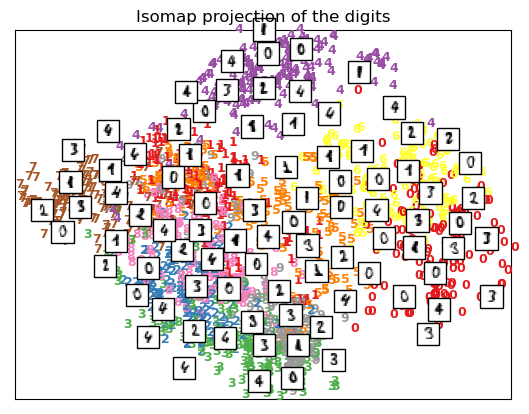

In [144]:
# distance matrix 계산
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components
from scipy.sparse.csgraph import shortest_path

def isomap(input, n_neighbors, n_components, n_jobs):
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='auto', metric='minkowski', p=2).fit(X)
    nbg = kneighbors_graph(nbrs, n_neighbors=20, metric='minkowski', p=2)

    n_connected_components, labels = connected_components(nbg)
    
    distance_matrix = shortest_path(nbg, method = 'auto', directed=False)
    kernel_pca = KernelPCA(n_components=n_components, kernel="precomputed", eigen_solver='arpack', n_jobs=n_jobs)
    
    Z = distance_matrix ** 2
    Z *= -0.5
    embedding = kernel_pca.fit_transform(Z)
    return embedding

def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

embedding = isomap(input=X, n_neighbors=n_neighbors, n_components=2, n_jobs=4)

plot_embedding(embedding,"Isomap projection of the digits" )


## LLE

### LLE(Locally Linear Embedding)
LLE는 manifold learning의 일종이다. 기존 데이터의 structure를 유지하는 형태로 학습되며 두 가지 가정 하에서 차원 축소가 가능하다. 
- 데이터가 밀도 높게 sampling 되어있다. (데이터 포인트의 neighborhood 포인트가 최소 20개 이상) 
- 데이터가 smooth한 manifold에 위치해있다. (데이터의 분포가 급격하게 꺾이는 부분이나 특정 부분에 위치하지 않는 구멍이 있거나 하면 좋지 않다는 의미)

### Procedure
1. Neighborhood graph 생성
    - $\epsilon$-neighborhood: $\epsilon$ 보다 작은 거리일때 연결
    - k-nearest neighborhood: k-nearest 알고리즘으로 판단된 주변 데이터 포인트들을 이웃이라 생각하고 연결
2. Weight matrix 계산
    - 각 데이터 포인트는 neighborhood 포인트들이 weight sum으로 reconstruction된다. 
    - 이 neighborhood 포인트들의 weight들을 학습하는 것이고, 이웃이 아닌 포인트들의 weight은 0이다. 
    - 이웃의 가중치만 사용하기 때문에 Locally라는 이름을 가지며 이웃 포인트들의 가중치를 선형계수로 사용하기에 linear란 이름을 갖는다. 
    - 각 데이터 포인트마다 그 데이터 포인트의 이웃들의 weight sum과의 차이를 구하고, 모든 포인트에 대해서 이 차이를 합산한 것이 cost이다. 

3. Embedding
    - 두 번째 단계에서 구해진 weight을 이용해 저차원 데이터 포인트들을 계산    


In [104]:
from scipy.sparse.linalg import eigsh

def LLE(X, n_neighbors, n_components):

    x_matrix = np.asmatrix(X).T
    D, N = x_matrix.shape

    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    distance = np.asmatrix(D)

    index=np.argsort(distance,axis=0)
    neighborhood = index[1:(n_neighbors+1),:]

    W = np.zeros((n_neighbors,N))
    tol = 1e-2


    # for variables
    for i in range(N):
        z = x_matrix[:, np.array(neighborhood[:,i]).reshape(-1)] - np.tile(x_matrix[:,i],(1,n_neighbors)) # shift ith pt to origi
        C = z.T*z # local covariance
        C = C + np.eye(n_neighbors) * tol * np.trace(C)
        I = np.ones((n_neighbors))
        W[:,i] = np.linalg.solve(np.array(C),I)
        W[:,i] = W[:,i]/sum(W[:,i])


    M = np.eye(N)  # M = (I-W)' (I-W)

    for i in range(N):
        w = W[:, i]
        j = neighborhood[:, i]
        M[i, j] = M[i, j] - np.asmatrix(w).T
        M[j, i] = M[j, i] - np.asmatrix(w).T
        M[j, j] = M[j, j] + np.asmatrix(w*w.T).T

    eigenvals, Y = eigsh(M, n_components + 1, tol=1e-3, sigma=0.0, maxiter = 100)

    return Y[:, 1:], np.sum(eigenvals[1:])

In [105]:
digits = datasets.load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 20

In [106]:
x_matrix = np.asmatrix(X).T
D, N = x_matrix.shape
print(D, N)

64 901


Computing LLE embedding


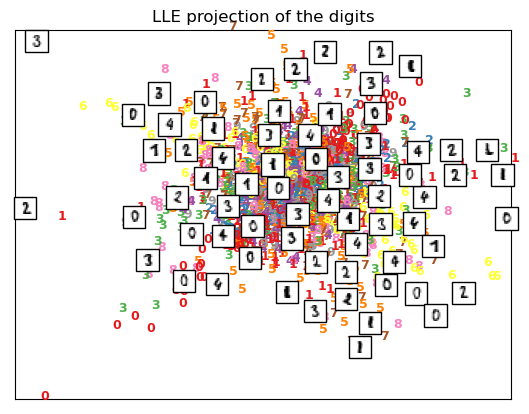

In [146]:
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


# LLE projection of the digits dataset
print("Computing LLE embedding")
embedding, _ = LLE(X=X, n_neighbors=n_neighbors, n_components=2)
plot_embedding(embedding,"LLE projection of the digits")

# t-SNE
## SNE(Stochastic Neighbor Embedding)
SNE는 고차원의 데이터를 저차원으로 임베딩할 때 neighborhood structure를 유지하려 한다.  
각 데이터 포인트마다 Gaussian distribution을 이용해 neighborhood의 확률값을 계산하며, 이 확률값이 고차원에서나 저차원에서나 유사하길 원한다.   
원래 차원과 임베딩된 이후의 저차원에서 두 객체간의 이웃 관계는 잘 보존 되어야한다.

$\ p_{j|i} = {e^{-{||x_i - x_j||^2 \over 2\sigma_i^2}} \over \sum_{k \neq i}e^{-{||x_i - x_k||^2 \over 2\sigma_i^2}}} $

수식에서 p는 고차원에서 i 라는 데이터 포인트에 대해 j라는 데이터 포인트가 이웃으로 뽑힐 확률값이다. 같은 의미로 q는 저차원에서의 확률값을 의미한다. 여기서 p는 기존 데이터셋을 통해 구할 수 있는 값이지만 q에서 y가 미지수이기 때문에 y를 학습해야한다. 

학습은 두 확률분포 p, q가 비슷해지도록 y값을 업데이트하면 된다. 두 확률분포의 차이를 측정하는 방법으로 Kullback-Leibler divergence를 사용한다.

$\ Cost = \sum_i{KL(P_i||Q_i)} = \sum_i\sum_j p_{j|i} log{p_{j|i}\over q_{j|i}} $

Cost를 학습하고자 하는 y에 대해 gradient를 계산하면 원래는 첫 번째 수식처럼 나오지만, i와 j를 바꿨을 때의 p, q값이 크게 다르지 않다는 점을 고려해 수식을 간결하게 하면 두번째 수식이 나온다. 이를 Symmetric SNE라고 하며 해당 gradient를 가지고 우리가 알고 있는 최적화 방법을 통해 학습하면 된다. 

$ \text{(1): } {\partial C \over \partial y_i} = 2\sum_j(y_j - y_i)(p_{j|i} - q_{j|i} + p_{i|j} - q+{i|j}) \\
\text{(2): } {\partial C \over \partial y_i} = 4\sum_j(y_j - y_i)(p_{ij} - q_{ij}) $

## t-SNE
SNE를 사용하면 Crowding problem이 발생한다. 데이터를 저차원으로 축소했을 때 각 포인트들이 너무 밀집되어 구분이 어려운 문제이다. SNE는 가우시안 분포를 사용하기 때문에 분포에서 멀어질수록 확률 밀도 값이 급격히 떨어지기 때문에 발생하는 문제이다. 따라서 가우시안 분포 대신 확률 밀도 값이 급격히 떨어지지 않는 t분포를 활용한다. 

$\ q_{j|i} = {(1+||y_i - y_j||^2)^{-1} \over \sum_{k \neq j}(1+||y_k-y_j||^2)^{-1}} $



In [127]:
digits = datasets.load_digits(n_class=5)
X = digits.data
y = digits.target
n_samples, n_features = X.shape

In [145]:
def neg_distance(X):
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D


def softmax(X):
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    np.fill_diagonal(e_x, 0.)

    e_x = e_x + 1e-8

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

def calc_prob_matrix(distances, sigmas=None):
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)


def binary_search(fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess


def _perplexity(prob_matrix):
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas):
    return _perplexity(calc_prob_matrix(distances, sigmas))


def find_optimal_sigmas(distances, target_perplexity):
    sigmas = []
    for i in range(distances.shape[0]):
        fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        correct_sigma = binary_search(fn, target_perplexity)
        sigmas.append(correct_sigma)
    return np.array(sigmas)


def p_conditional_to_joint(P):
    return (P + P.T) / (2. * P.shape[0])

def p_joint(X, target_perplexity):
    distances = neg_distance(X)
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    p_conditional = calc_prob_matrix(distances, sigmas)
    P = p_conditional_to_joint(p_conditional)
    return P

def q_joint(Y):
    inv_distances = neg_distance(Y)
    distances = np.power(1. - inv_distances, -1)
    np.fill_diagonal(distances, 0.)
    return distances / np.sum(distances), distances

def tsne_grad(P, Q, Y, distances):
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)

    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)
    distances_expanded = np.expand_dims(distances, 2)
    y_diffs_wt = y_diffs * distances_expanded

    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad



def t_SNE(X, num_component, num_iters = 500, learning_rate = 10, momentum = 0.9):

    Y = np.random.normal(0., 0.0001,[X.shape[0], num_component])
    P = p_joint(X, 20)

    if momentum:
        Y_m2 = Y
        Y_m1 = Y

    for i in range(num_iters):

        Q, distances = q_joint(Y)
        grads = tsne_grad(P, Q, Y, distances)
        Y = Y - learning_rate * grads
        if momentum:
            Y += momentum * (Y_m1 - Y_m2)
            Y_m2 = Y_m1
            Y_m1 = Y
            
    return Y

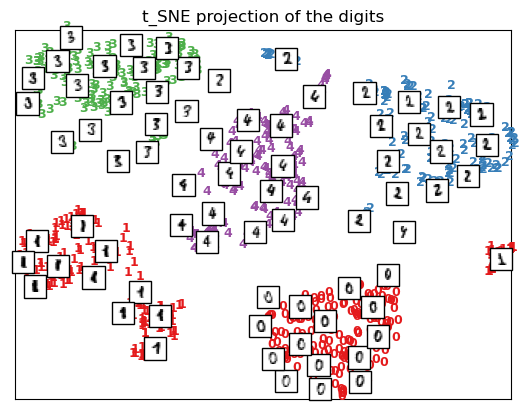

In [129]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):

        shown_images = np.array([[1., 1.]])  
        for i in range(digits.data.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                continue
            
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)


embedding = t_SNE(X = X, num_component = 2)

plot_embedding(embedding,"t_SNE projection of the digits" )